In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split

In [8]:
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

def load_images_label_pairs(image_dir, label_dir, step=1, step_size=1000):
    image_files = sorted(os.listdir(image_dir))  # Sort to maintain consistency
    label_files = sorted(os.listdir(label_dir))

    images =[]
    labels=[]

    # currupted_images = [2355, 2365, 2366]
    print("Images count: " + str(len(image_files)))
    for img, label in zip(image_files[step * step_size: (step + 1) * step_size], label_files[step * step_size: (step + 1) * step_size]):
        img_path = os.path.join(image_dir, img)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Adjust if images are colored
        images.append(img)


        label_path = os.path.join(label_dir, label)
        label = np.load(label_path)
        label = cv2.resize(label, (128, 128))  # Resize to match the image size
        labels.append(label)


    return np.array(images), np.array(labels)


# Print the shapes of the resulting datasets


In [16]:
# Dice Loss
def dice_loss(y_true, y_pred):
    smooth = 1.0
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

# Learning Rate Scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

# Lightweight U-Net Model
def lightweight_unet_model(input_size=(None, None, 1), target_size=(128, 128)):
    # Input layer with flexible dimensions
    inputs = Input(input_size)
    
    # Preprocessing layers
    # Resizing layer
    x = tf.keras.layers.Resizing(target_size[0], target_size[1])(inputs)
    
    # Normalization layer (scales values to 0-1 range)
    x = tf.keras.layers.Rescaling(1./255)(x)
    
    # Encoder
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    # Bottleneck
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    
    # Decoder
    u4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(u4)
    c4 = BatchNormalization()(c4)
    
    u5 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(u5)
    c5 = BatchNormalization()(c5)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)
    
    model = Model(inputs, outputs)
    
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy',  # You could also use your dice_loss here
                  metrics=['accuracy'])
    return model

In [17]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=6144)])  # 6GB in MB
    except RuntimeError as e:
        print(e)


# Create model with flexible input size
light_unet = lightweight_unet_model(input_size=(None, None, 1), target_size=(128, 128))
# light_unet.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = LearningRateScheduler(scheduler)

image_dir_path = '/home/yasas/GazeEstimation/openEDS/openEDS/train/images'
label_dir_path = '/home/yasas/GazeEstimation/openEDS/openEDS/train/labels'


images, labels = load_images_label_pairs(image_dir_path, label_dir_path, step=0, step_size=2000)
labels = labels / np.max(labels)

print(f"Max label size: {np.max(labels)}")
unique_classes = np.unique(labels)
print(f"Number of label classes: {len(unique_classes)}")
print(f"Label classes: {unique_classes}")

img_train, img_test, label_train, label_test = train_test_split(images, labels, test_size=0.2, random_state=42)
total_iterations = 2
images_per_iteration =  len(img_train) // total_iterations
validation_size = len(img_test) // total_iterations

print(f"Training images shape: {img_train.shape}")
print(f"Training labels shape: {label_train.shape}")
print(f"Testing images shape: {img_test.shape}")
print(f"Testing labels shape: {label_test.shape}")

Virtual devices cannot be modified after being initialized
Images count: 27431
Max label size: 1.0
Number of label classes: 4
Label classes: [0.         0.33333333 0.66666667 1.        ]
Training images shape: (1600, 400, 640)
Training labels shape: (1600, 128, 128)
Testing images shape: (400, 400, 640)
Testing labels shape: (400, 128, 128)


In [15]:
history = light_unet.fit(
        img_train, label_train,
        validation_data=(img_test, label_test),
        epochs=50,
        batch_size=5,
        callbacks=[early_stopping, lr_scheduler],
        shuffle=True
    )
    
        
# Save the model
light_unet.save('light_weight_unet_gaze_estimation_model_2.h5')  # <-- Typo fixed

Epoch 1/50


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(5, 128, 128), output.shape=(5, 128, 128, 4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
(128, 128)


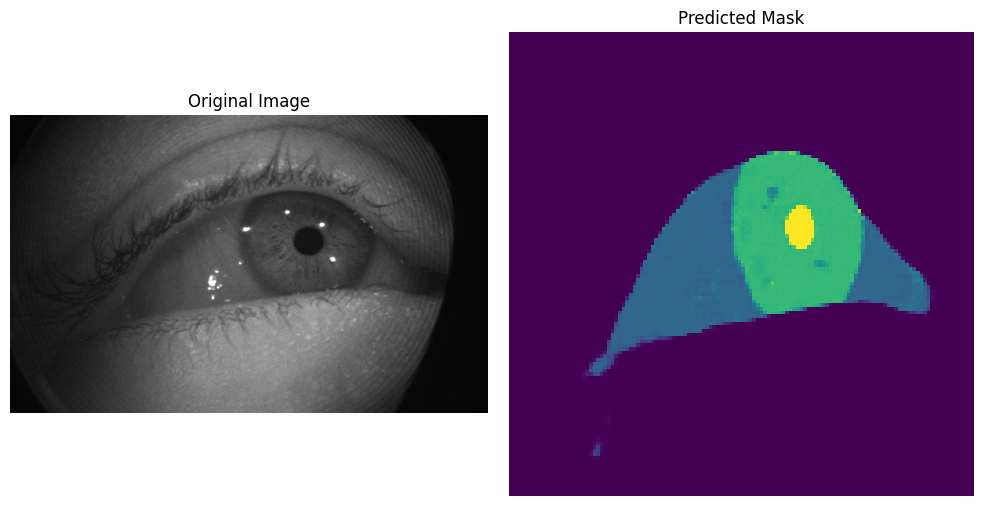

In [ ]:
# Re-define dice_loss again (important!)
def dice_loss(y_true, y_pred):
    smooth = 1.0
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

# Now load the model properly
model = load_model('light_weight_unet_gaze_estimation_model_2.h5', custom_objects={'dice_loss': dice_loss})

# Define the path to the image you want to predict
image_path = '/home/yasas/GazeEstimation/openEDS/openEDS/S_192/45.png'  # Assuming grayscale image
# image_path = '/home/yasas/GazeEstimation/412.jpg'  # Assuming grayscale image

# Load the image using OpenCV
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# No need to resize or normalize manually since these operations are part of the model
# Simply prepare the input with proper dimensions
int_image = np.expand_dims(image, axis=0)  # Add batch dimension: (1, height, width)
input_image = np.expand_dims(int_image, axis=-1)  # Add channel dimension: (1, height, width, 1)

# Predict the output using the model
predicted_mask = model.predict(input_image)

# Remove batch dimension to get the mask image
predicted_mask = predicted_mask[0, :, :, 0]  # Shape: (height, width)

for i in range(predicted_mask.shape[0]):
    for j in range(predicted_mask.shape[1]):
        if predicted_mask[i][j] > 0.9:
            predicted_mask[i][j] = 0.99
        elif predicted_mask[i][j] > 0.4:
            predicted_mask[i][j] = 0.67
        elif predicted_mask[i][j] > 0.2:
            predicted_mask[i][j] = 0.33
        else:
            predicted_mask[i][j] = 0
# predicted_mask = predicted_mask.astype(np.uint8)  # Convert to uint8 for display

# Save original image dimensions for display
original_shape = image.shape
# Display the original image and the predicted mask side by side

print(predicted_mask.shape)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask)
plt.title('Predicted Mask')
plt.axis('off')

plt.tight_layout()
plt.show()

# Optional: If you need to save the mask
# cv2.imwrite('predicted_mask.png', (predicted_mask * 255).astype(np.uint8))

In [ ]:
from tensorflow.keras.utils import model_to_dot
import pydot
from IPython.display import Image

dot = model_to_dot(model, show_shapes=True, show_layer_names=True, dpi=300)  # High DPI
dot.set_rankdir('TB')  # Top-Bottom layout

# Save the PNG
dot.write_png('model_plot.png')

# Display
Image(filename='model_plot.png')



In [6]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 1)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing (Resizing) │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ resizing[0][0]    │
│ (Rescaling)         │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        320 │ rescaling[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │     32,832 │ conv2d_2[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     73,792 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 128, 128,  │      8,224 │ batch_normalizat… │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     18,464 │ concatenate_1[0]

 Total params: 226,787 (885.89 KB)

 Trainable params: 226,401 (884.38 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 2 (12.00 B)

In [20]:

def round_predictions(y_pred):
    y_pred_rounded = np.zeros_like(y_pred)
    y_pred_rounded[y_pred > 0.9] = 1
    y_pred_rounded[(y_pred > 0.4) & (y_pred <= 0.9)] = 0.67
    y_pred_rounded[(y_pred > 0.2) & (y_pred <= 0.4)] = 0.33
    y_pred_rounded[y_pred <= 0.2] = 0.0
    return y_pred_rounded

400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


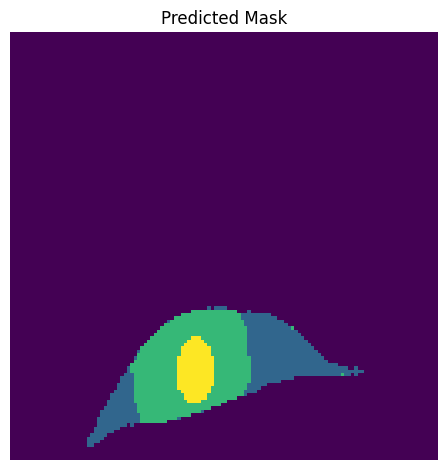

In [ ]:
def dice_loss(y_true, y_pred):
    smooth = 1.0
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

# Now load the model properly
model = load_model('light_weight_unet_gaze_estimation_model_2.h5', custom_objects={'dice_loss': dice_loss})
# Expand dims to add channel (1 for grayscale)
X_test_fixed = np.expand_dims(img_train, axis=-1)  # Shape: (1600, 400, 640, 1)

# Now predict
y_pred = model.predict(X_test_fixed, batch_size=4, verbose=1)

plt.imshow(round_predictions(y_pred[0]))
plt.title('Predicted Mask')
plt.axis('off')

plt.tight_layout()
plt.show()


In [22]:
def calculate_miou_multiclass(y_true, y_pred, classes):
    ious = []
    for cls in classes:
        true_mask = (y_true == cls).astype(np.float32)
        pred_mask = (y_pred == cls).astype(np.float32)

        true_mask = (abs(y_true - cls)< 0.01).astype(np.float32)
        pred_mask = (abs(y_pred - cls) < 0.01).astype(np.float32)

        intersection = np.sum(true_mask * pred_mask)
        union = np.sum(true_mask) + np.sum(pred_mask) - intersection

        if union > 0:
            iou = intersection / union
        else:
            iou = 1.0  # If both true and pred are empty
        ious.append(iou)

    return np.mean(ious)

unique_classes = np.unique(labels)
y_pred_squeeze = np.squeeze(y_pred, axis = -1)  # Remove batch dimension
miou_score = calculate_miou_multiclass(y_pred_squeeze, label_train, classes=unique_classes)
print(f"mIoU: {miou_score:.4f}")


mIoU: 0.8759


In [25]:
def dice_score(y_true, y_pred, num_classes):
    dices = []
    for cls in num_classes:
        true_mask = (abs(y_true - cls)< 0.01).astype(np.float32)
        pred_mask = (abs(y_pred - cls) < 0.01).astype(np.float32)
        
        print(np.sum(true_mask))
        print(np.sum(pred_mask))

        intersection = 2.0 * np.sum(true_mask * pred_mask)
        denominator = np.sum(true_mask) + np.sum(pred_mask)

        dice = intersection / denominator if denominator > 0 else 1.0
        dices.append(dice)
        print(f"Dice for class {cls}: {dice:.4f}")

    mean_dice = np.mean(dices)
    print(f"\nMean Dice: {mean_dice:.4f}")
    return mean_dice

unique_classes = np.unique(labels)
num_classes = 4  # Example: background, iris, pupil
y_pred_squeeze = np.squeeze(y_pred, axis = -1)  # Remove batch dimension
miou_score = dice_score(y_pred_squeeze, label_train, num_classes=unique_classes)
unique_classes = np.unique(y_pred_squeeze)
print(f"Unique classes in predicted mask: {unique_classes}")
print(f"Dice coefficient is : {miou_score:.4f}")

22184128.0
22348140.0
Dice for class 0.0: 0.9963
1255716.0
1760436.0
Dice for class 0.3333333333333333: 0.8312
1662258.0
1932622.0
Dice for class 0.6666666666666666: 0.9245
162874.0
173205.0
Dice for class 1.0: 0.9692

Mean Dice: 0.9303
Unique classes in predicted mask: [9.3157426e-13 1.8755789e-12 2.1931335e-12 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
Dice coefficient is : 0.9303
